In [15]:
import scipy.io
import numpy as np
import PIL
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import segmentation_models_pytorch as smp

from sky_segmentation.modules.networks import SkySegmentationModel
import os
import csv
import json
import torch
from mit_semseg.utils import colorEncode

In [16]:
colors = scipy.io.loadmat('../artifacts/data/metadata/color150.mat')['colors']
names = {}
with open('../artifacts/data/metadata/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')
        
    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(np.uint8)

    # aggregate images and save
    im_vis = np.concatenate((img, pred_color), axis=1)
    display(PIL.Image.fromarray(im_vis))


In [17]:
experiment_name = "sky_segmentation-2023-02-13-20-59-24"
MODEL_DIR = "../artifacts/models/"
model = SkySegmentationModel.load_from_checkpoint(
        checkpoint_path=os.path.join(MODEL_DIR, experiment_name, "last.ckpt"),
        architecture="unet",
        encoder_name="resnet18",
        learning_rate=1e-4,
        in_channels=3,
        out_classes=1,
)

In [18]:
params = smp.encoders.get_preprocessing_params("resnet18")
test_transform = A.Compose(
        [
            A.PadIfNeeded(
                pad_height_divisor=32,
                pad_width_divisor=32,
                min_height=None,
                min_width=None,
                position="top_left",
                border_mode=0,
                value=0,
                always_apply=False,
                p=1.0,
            ),
            A.Normalize(mean=params["mean"], std=params["std"]),
            ToTensorV2(),
        ]
    )

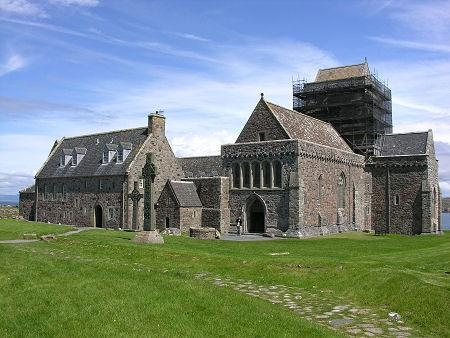

In [19]:
path = "../artifacts/data/ADEChallengeData2016/images/training/ADE_train_00000983.jpg"
segmentation_path = "../artifacts/data/ADEChallengeData2016/annotations/training/ADE_train_00000983.png"
segmentation_mask = PIL.Image.open(segmentation_path)
pil_image = PIL.Image.open(path).convert('RGB')
original_image_size = pil_image.size
img_original = np.array(pil_image)
img_data = test_transform(image=img_original)["image"].unsqueeze(0)
pil_image

In [20]:
logits_mask = model(img_data)
logits_mask = logits_mask[:, :, : original_image_size[1], : original_image_size[0]]
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5).float()

pred_mask = pred_mask.squeeze().detach().cpu().numpy()

In [22]:
# convert 1 mask to 2 
pred_mask = np.where(pred_mask == 1, 2, pred_mask)
# convert 0 mask to -1
pred_mask = np.where(pred_mask == 0, -1, pred_mask)

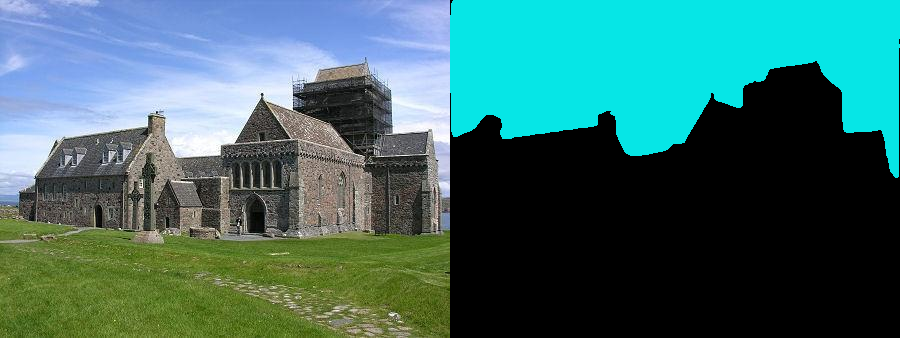

In [23]:
visualize_result(img_original, pred_mask)

In [24]:
np_segmentation_mask = np.array(segmentation_mask)
np_segmentation_mask = np.where(
            np_segmentation_mask==3,
            2*np.ones_like(np_segmentation_mask),
            -1*np.zeros_like(np_segmentation_mask),
        )


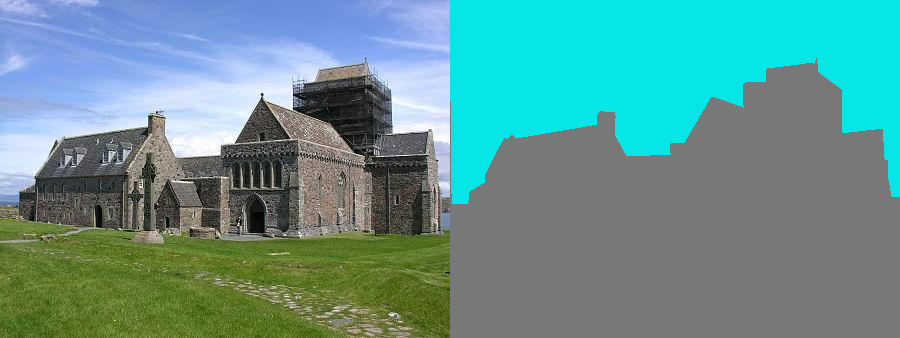

In [25]:

visualize_result(img_original, np_segmentation_mask)